In [1]:
import rioxarray
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import h5py
from rasterio.transform import from_origin
import rasterio

# NDVI

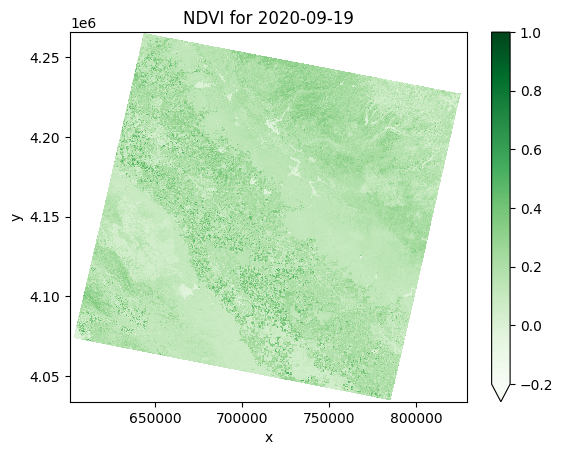

Saved ndvi_2017-09-27.tif
Saved ndvi_2020-09-19.tif
Saved ndvi_2023-09-28.tif


In [2]:
# Function to calculate NDVI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

red_band_paths = [
    'data/landsat/2017/LC08_L2SP_043034_20170927_20200903_02_T1_SR_B4.TIF', 
    'data/landsat/2020/LC08_L2SP_043034_20200919_20201006_02_T1_SR_B4.TIF', 
    'data/landsat/2023/LC08_L2SP_043034_20230928_20231003_02_T1_SR_B4.TIF'
]
nir_band_paths = [
    'data/landsat/2017/LC08_L2SP_043034_20170927_20200903_02_T1_SR_B5.TIF', 
    'data/landsat/2020/LC08_L2SP_043034_20200919_20201006_02_T1_SR_B5.TIF', 
    'data/landsat/2023/LC08_L2SP_043034_20230928_20231003_02_T1_SR_B5.TIF'
]

red_bands = [rioxarray.open_rasterio(fp) for fp in red_band_paths]
nir_bands = [rioxarray.open_rasterio(fp) for fp in nir_band_paths]

red_data = xr.concat(red_bands, dim='time')
nir_data = xr.concat(nir_bands, dim='time')

time_index = pd.to_datetime(['2017-09-27', '2020-09-19', '2023-09-28'])

red_data = red_data.assign_coords(time=time_index)
nir_data = nir_data.assign_coords(time=time_index)

ndvi_data = calculate_ndvi(nir_data, red_data)

specific_time = '2020-09-19'
ndvi_data.sel(time=specific_time).plot(cmap='Greens', vmin=-0.2, vmax=1)
plt.title(f'NDVI for {specific_time}')
plt.show()


# export to folder
for i, time in enumerate(ndvi_data.time):
    output_path = f'ndvi_{str(time.values)[:10]}.tif'
    ndvi_slice = ndvi_data.sel(time=time)

    ndvi_slice.rio.to_raster(output_path)
    print(f'Saved {output_path}')


In [3]:
# ndvi paths
ndvi_tif_paths = ['ndvi_2017-09-27.tif', 'ndvi_2020-09-19.tif', 'ndvi_2023-09-28.tif']

dates = []
ndvi_values = []
geometries = []

for tif_path in ndvi_tif_paths:
    date_str = os.path.splitext(tif_path)[0].split('_')[1]

    ndvi_data = rioxarray.open_rasterio(tif_path)
    
    lons, lats = ndvi_data.coords['x'].values, ndvi_data.coords['y'].values
    for lon, lat in zip(lons.flatten(), lats.flatten()):
        ndvi_val = ndvi_data.sel(x=lon, y=lat, method="nearest").values.item()
        if not np.isnan(ndvi_val):  # Check for NaN values
            ndvi_values.append(ndvi_val)
            dates.append(date_str)
            geometries.append(Point(lon, lat))

# DATAFRAME
df = pd.DataFrame({'Date': dates, 'NDVI': ndvi_values})

# GDF
gdf = gpd.GeoDataFrame(df, geometry=geometries)
# Extract latitude and longitude from the geometry column
gdf['latitude'] = gdf.geometry.y
gdf['longitude'] = gdf.geometry.x

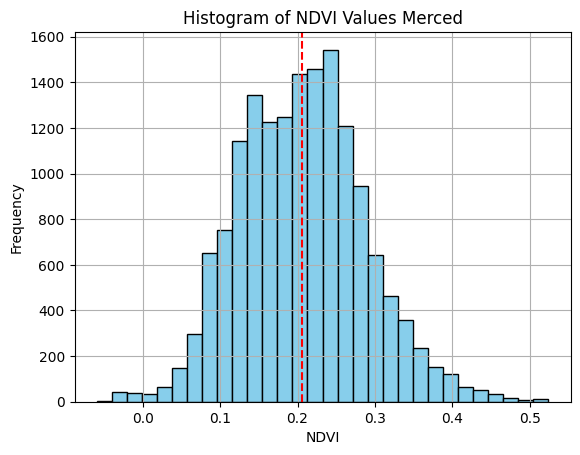

In [5]:
# Plot histogram of NDVI values
plt.hist(gdf['NDVI'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of NDVI Values Merced')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.axvline(x=0.20590845482830442, color='red', linestyle='--', label='Value')
plt.grid(True)
plt.show()

In [6]:
average_ndvi_gdf = gdf['NDVI'].mean()
average_ndvi_gdf

0.20590845482830442

In [7]:
# make a subset of 2017
gdf_2017 = gdf[gdf['Date'].str.startswith('2017')]

gdf_2017 = gdf_2017.set_crs(epsg=32610)

In [8]:
# make a subset of 2020
gdf_2020 = gdf[gdf['Date'].str.startswith('2020')]

gdf_2020 = gdf_2020.set_crs(epsg=32610)

In [9]:
# make a subset of 2023
gdf_2023 = gdf[gdf['Date'].str.startswith('2023')]

gdf_2023 = gdf_2023.set_crs(epsg=32610)

# SOIL MOISTURE 

In [10]:
# 2023

soil_2023_filename = "data/soilmoisture/SMAP_L2_SM_P_E_46274_D_20230930T142228_R18290_001.h5"
h5_2023 = h5py.File(soil_2023_filename, 'r')

# Get the data
latitude_2023 = h5_2023['Soil_Moisture_Retrieval_Data/latitude'][:].flatten()
longitude_2023 = h5_2023['Soil_Moisture_Retrieval_Data/longitude'][:].flatten()
soil_moisture_2023 = h5_2023['Soil_Moisture_Retrieval_Data/soil_moisture'][:].flatten()

# Create DataFrame
soil_2023_data = pd.DataFrame({'Latitude': latitude_2023, 'Longitude': longitude_2023, 'Soil Moisture': soil_moisture_2023})

# Create GeoDataFrame
gdf_sm_2023 = gpd.GeoDataFrame(soil_2023_data, geometry=gpd.points_from_xy(soil_2023_data.Longitude, soil_2023_data.Latitude), crs="EPSG:4326")

# remove invalid 
clean_soil_moisture_2023 = gdf_sm_2023[gdf_sm_2023['Soil Moisture'] != -9999.0]

In [13]:
# 2020 Soil moisture data 

# Load the 2020 sm
soil_2020_filename = "data/soilmoisture/SMAP_L3_SM_P_E_20200918_R19240_001.h5"
h5_2020 = h5py.File(soil_2020_filename, 'r')

# Get the data
latitude_2020 = h5_2020['Soil_Moisture_Retrieval_Data_AM/latitude'][:].flatten()
longitude_2020 = h5_2020['Soil_Moisture_Retrieval_Data_AM/longitude'][:].flatten()
soil_moisture_2020 = h5_2020['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:].flatten()

# make df
soil_2020_data = pd.DataFrame({'Latitude': latitude_2020, 'Longitude': longitude_2020, 'Soil Moisture': soil_moisture_2020})

# make gdf
gdf_sm_2020 = gpd.GeoDataFrame(soil_2020_data, geometry=gpd.points_from_xy(soil_2020_data.Longitude, soil_2020_data.Latitude), crs="EPSG:4326")

# get rid of invalid 
clean_soil_moisture_2020 = gdf_sm_2020[gdf_sm_2020['Soil Moisture'] != -9999.0]

In [14]:
clean_soil_moisture_2020_reproj = clean_soil_moisture_2020.to_crs(epsg=32610)

In [16]:
# 2017 Soil moisture data 
# Load the 2017 soil moisture data
soil_2017_filename = "data/soilmoisture/SMAP_L3_SM_P_E_20170917_R19240_001.h5"
h5_2017 = h5py.File(soil_2017_filename, 'r')

# Get the data
latitude_2017 = h5_2017['Soil_Moisture_Retrieval_Data_AM/latitude'][:].flatten()
longitude_2017 = h5_2017['Soil_Moisture_Retrieval_Data_AM/longitude'][:].flatten()
soil_moisture_2017 = h5_2017['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:].flatten()

# Create dataframe
soil_2017_data = pd.DataFrame({'Latitude': latitude_2017, 'Longitude': longitude_2017, 'Soil Moisture': soil_moisture_2017})

# GDF
gdf_sm_2017 = gpd.GeoDataFrame(soil_2017_data, geometry=gpd.points_from_xy(soil_2017_data.Longitude, soil_2017_data.Latitude), crs="EPSG:4326")

# remove invalid
clean_soil_moisture_2017 = gdf_sm_2017[gdf_sm_2017['Soil Moisture'] != -9999.0]

In [17]:
clean_soil_moisture_2017_reproj = clean_soil_moisture_2017.to_crs(epsg=32610)

# MERGE for 2017 and 2020

In [18]:
# 2023
buffer_distance = 1000  # Specify the buffer distance in CRS units (metre)
clean_soil_moisture_2023_reproj['Buffered Geometry'] = clean_soil_moisture_2023_reproj.geometry.buffer(buffer_distance)
clean_soil_moisture_2023_reproj.geometry = clean_soil_moisture_2023_reproj['Buffered Geometry']
clean_soil_moisture_2023_reproj.head(3)

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry
156075,49.920986,-126.924271,0.686689,"POLYGON ((219335.896 5537231.496, 219331.080 5...","POLYGON ((219335.896 5537231.496, 219331.080 5..."
156076,49.812294,-126.924271,0.686612,"POLYGON ((218702.343 5525151.677, 218697.528 5...","POLYGON ((218702.343 5525151.677, 218697.528 5..."
156641,50.358204,-126.830910,0.670774,"POLYGON ((228532.874 5585477.698, 228528.059 5...","POLYGON ((228532.874 5585477.698, 228528.059 5..."


In [19]:
merge_2023 = clean_soil_moisture_2023_reproj.sjoin(gdf_2023, how="inner")
merge_2023.shape

(274, 10)

In [20]:
# gdf_2017.set_crs(epsg=4326)

gdf_2017.crs == clean_soil_moisture_2017_reproj.crs

True

In [21]:
# 2017
buffer_distance = 1000  
clean_soil_moisture_2017_reproj['Buffered Geometry'] = clean_soil_moisture_2017_reproj.geometry.buffer(buffer_distance)
clean_soil_moisture_2017_reproj.geometry = clean_soil_moisture_2017_reproj['Buffered Geometry']
clean_soil_moisture_2017_reproj.head(3)

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry
32572,80.375343,-18.998962,0.271269,"POLYGON ((1547915.478 10260250.624, 1547910.66...","POLYGON ((1547915.478 10260250.624, 1547910.66..."
32573,80.375343,-18.905602,0.274193,"POLYGON ((1547481.071 10261962.343, 1547476.25...","POLYGON ((1547481.071 10261962.343, 1547476.25..."
32574,80.375343,-18.812241,0.278121,"POLYGON ((1547043.846 10263673.325, 1547039.03...","POLYGON ((1547043.846 10263673.325, 1547039.03..."


In [22]:
merge_2017 = clean_soil_moisture_2017_reproj.sjoin(gdf_2017, how="inner")

In [23]:
# 2020 
buffer_distance_2020 = 1000  

clean_soil_moisture_2020_reproj['Buffered Geometry'] = clean_soil_moisture_2020_reproj.geometry.buffer(buffer_distance_2020)

clean_soil_moisture_2020_reproj.geometry = clean_soil_moisture_2020_reproj['Buffered Geometry']

In [24]:
merge_2020 = clean_soil_moisture_2020_reproj.sjoin(gdf_2020, how="inner")
merge_2020.shape

(274, 10)

In [25]:
merge_2020.head(3)

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry,index_right,Date,NDVI,latitude,longitude
1192131,38.186245,-121.415977,0.160548,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",5356,2020-09-19,0.250990,4227270.0,639630.0
1192131,38.186245,-121.415977,0.160548,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",5355,2020-09-19,0.246252,4227300.0,639600.0
1192131,38.186245,-121.415977,0.160548,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",5354,2020-09-19,0.240574,4227330.0,639570.0


In [26]:
print(merge_2017.shape)
print(merge_2020.shape)
print(merge_2023.shape)

(132, 10)
(274, 10)
(274, 10)


## MERGE ALL

In [27]:

merged_all = pd.concat([merge_2017, merge_2020, merge_2023], ignore_index=True)



In [28]:
merged_all.head(3)

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry,index_right,Date,NDVI,latitude,longitude
0,37.033253,-120.015564,0.111371,"POLYGON ((766460.945 4102727.343, 766456.130 4...","POLYGON ((766460.945 4102727.343, 766456.130 4...",4298,2017-09-27,0.133891,4101810.0,765090.0
1,37.033253,-120.015564,0.111371,"POLYGON ((766460.945 4102727.343, 766456.130 4...","POLYGON ((766460.945 4102727.343, 766456.130 4...",4297,2017-09-27,0.140817,4101840.0,765060.0
2,37.033253,-120.015564,0.111371,"POLYGON ((766460.945 4102727.343, 766456.130 4...","POLYGON ((766460.945 4102727.343, 766456.130 4...",4296,2017-09-27,0.144316,4101870.0,765030.0


In [29]:
merged_all.shape

(680, 10)

In [30]:
# add column to merged_xxxx of correlation 
correlation = merge_2017['NDVI'].corr(merge_2017['Soil Moisture'])

# add columns
merge_2017['Correlation'] = correlation

In [31]:
# add column to merged_xxxx of correlation 
correlation = merge_2020['NDVI'].corr(merge_2020['Soil Moisture'])

# Add column
merge_2020['Correlation'] = correlation

In [32]:
# add column to merged_xxxx of correlation 
correlation = merge_2023['NDVI'].corr(merge_2023['Soil Moisture'])

# add columns
merge_2023['Correlation'] = correlation

In [33]:
# verify 
merge_2023

,Latitude,Longitude,Soil Moisture,geometry,Buffered Geometry,index_right,Date,NDVI,latitude,longitude,Correlation
184576,38.186245,-121.415977,0.188516,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",10602,2023-09-28,0.273261,4227270.0,639630.0,0.384102
184576,38.186245,-121.415977,0.188516,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",10601,2023-09-28,0.287355,4227300.0,639600.0,0.384102
184576,38.186245,-121.415977,0.188516,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",10600,2023-09-28,0.307689,4227330.0,639570.0,0.384102
184576,38.186245,-121.415977,0.188516,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",10599,2023-09-28,0.296384,4227360.0,639540.0,0.384102
184576,38.186245,-121.415977,0.188516,"POLYGON ((639724.693 4227665.295, 639719.878 4...","POLYGON ((639724.693 4227665.295, 639719.878 4...",10598,2023-09-28,0.303664,4227390.0,639510.0,0.384102
...,...,...,...,...,...,...,...,...,...,...,...
191160,36.769630,-119.735474,0.119103,"POLYGON ((792383.702 4074289.318, 792378.886 4...","POLYGON ((792383.702 4074289.318, 792378.886 4...",15674,2023-09-28,0.054078,4075110.0,791790.0,0.384102
191160,36.769630,-119.735474,0.119103,"POLYGON ((792383.702 4074289.318, 792378.886 4...","POLYGON ((792383.702 4074289.318, 792378.886 4...",15673,2023-09-28,0.082861,4075140.0,791760.0,0.384102
191160,36.769630,-119.735474,0.119103,"POLYGON ((792383.702 4074289.318, 792378.886 4...","POLYGON ((792383.702 4074289.318, 792378.886 4...",15672,2023-09-28,0.148107,4075170.0,791730.0,0.384102
191160,36.769630,-119.735474,0.119103,"POLYGON ((792383.702 4074289.318, 792378.886 4...","POLYGON ((792383.702 4074289.318, 792378.886 4...",15671,2023-09-28,0.130049,4075200.0,791700.0,0.384102


### Correlation

In [34]:
# 2020

In [35]:
# Calculate correlation coefficient
correlation_coefficient_2020 = merge_2020['NDVI'].corr(merge_2020['Soil Moisture'])

print(correlation_coefficient_2020)

0.3607792604462432


In [36]:
average_ndvi_2020 = merge_2020['NDVI'].mean()
average_ndvi_2020

0.1856840027999269

In [37]:
average_sm_2020 = merge_2020['Soil Moisture'].mean()
average_sm_2020

0.13476919

In [38]:
# 2017

In [39]:
correlation_coefficient_2017 = merge_2017['NDVI'].corr(merge_2017['Soil Moisture'])

print(correlation_coefficient_2017)

-0.5167216304294825


In [40]:
average_ndvi_2017 = merge_2017['NDVI'].mean()
average_ndvi_2017

0.13571634670634838

In [41]:
average_sm_2017 = merge_2017['Soil Moisture'].mean()
average_sm_2017

0.121359766

In [42]:
#2023
correlation_coefficient_2023 = merge_2023['NDVI'].corr(merge_2023['Soil Moisture'])

print(correlation_coefficient_2023)

0.3841015132658716


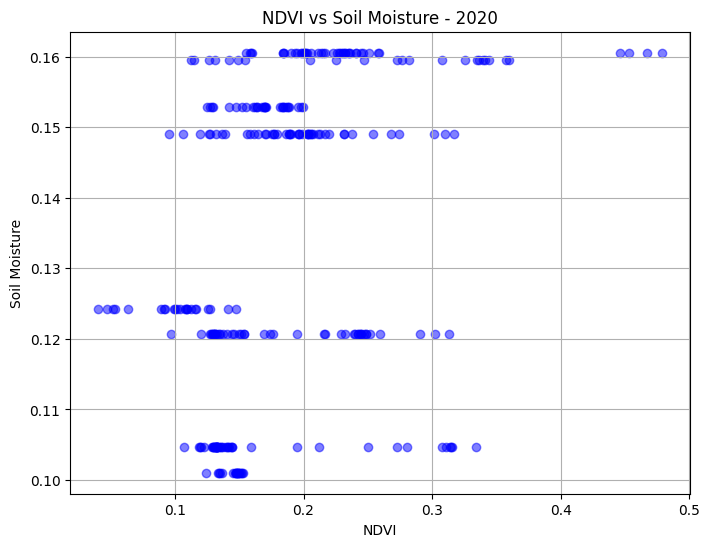

In [43]:
# plot ndvi vs sm
plt.figure(figsize=(8, 6))
plt.scatter(merge_2020['NDVI'], merge_2020['Soil Moisture'], color='blue', alpha=0.5)
plt.title('NDVI vs Soil Moisture - 2020')
plt.xlabel('NDVI')
plt.ylabel('Soil Moisture')
plt.grid(True)
plt.show()

# TIME SERIES 

In [51]:
merced_merged_gdf = gpd.GeoDataFrame(pd.concat([merge_2017, merge_2020, merge_2023], ignore_index=True))

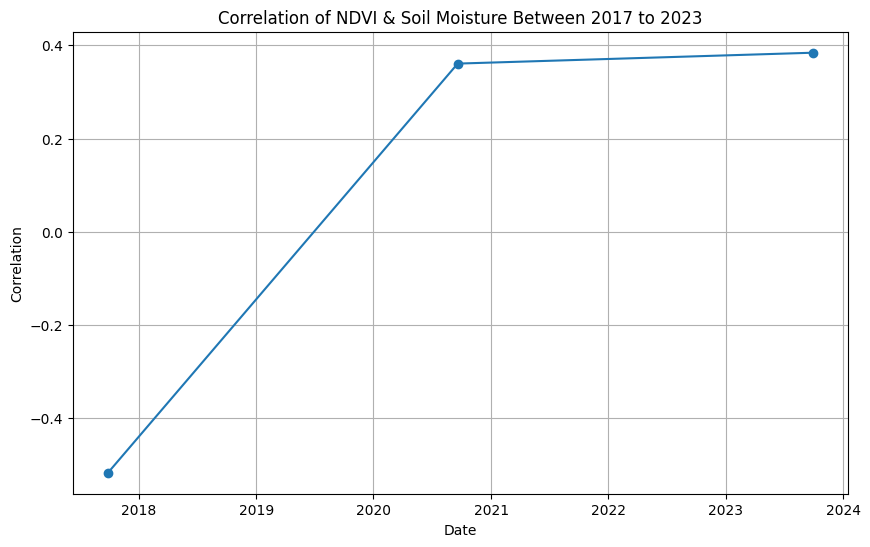

In [52]:
# plot
grouped = merced_merged_gdf.groupby('Date')['Correlation'].mean()

plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Correlation of NDVI & Soil Moisture Between 2017 to 2023')
plt.grid(True)
plt.show()